<a href="https://colab.research.google.com/github/Mafatihul/HateComment_Classification/blob/train/HateComment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install PySastrawi

In [3]:
import re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [5]:
nltk.download('stopwords')
stopwords.words('indonesian')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load Dataset

In [4]:
# Load file
# Slang dictionary for normalization
slang_dict = pd.read_csv(r"/content/drive/MyDrive/Skripsi/new_kamusalay.csv", encoding='latin-1', header=None)
slang_dict = slang_dict.rename(columns={0: 'original',
                                      1: 'replacement'})

# Load Hat
df = pd.read_csv (r"/content/drive/MyDrive/Skripsi/Dataset/HateComment_Dataset(New).csv", encoding='latin-1')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
test_df

,Texts,Is_HateComments
1398,cwe selalu benar ges,1
535,unsubscribe berjamaah yuk si ibu ga memanusiak...,1
1525,banyak orang yg lebih parah memperlakukan manu...,1
1017,kak tasyi aku nungguin konten ceramah nih biar...,1
1675,mungkin dibawahnya emang udah ada tempat sampa...,0
...,...,...
1769,saya unsubcirbe kalau tau begini mah.,1
347,buzzer,1
1244,kaaa bikin minimarket yang indomaret dongg,0
1851,wkwkwkwk....lucu banget.,1


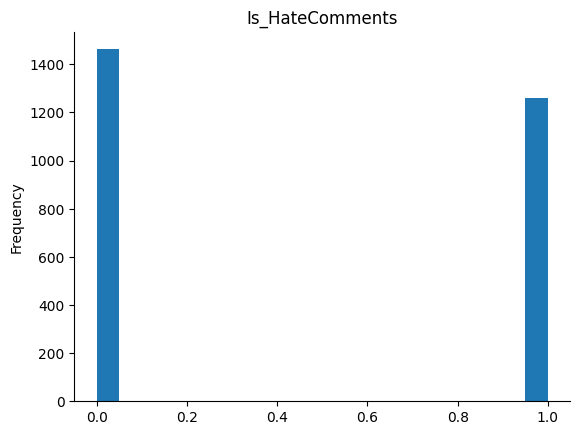

In [8]:
from matplotlib import pyplot as plt
df['Is_HateComments'].plot(kind='hist', bins=20, title='Is_HateComments')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Text Cleaning and Preprocessing


In [6]:

# Case folding teks data
def case_folding(comment):
  comment = comment.lower()
  # Menghapus mention
  comment = re.sub("@[A-Za-z0-9]+", ' ', comment)
  # Menghapus karakter non alphanumeric
  comment = re.sub(r"[^A-Za-z0-9\s]+", ' ', comment)
  # Menghapus spasi berlebih
  comment = re.sub(r'\s+', ' ', comment)
  return comment

# Normalisasi slang dan singkatan
slang_dict_map = dict(zip(slang_dict['original'], slang_dict['replacement']))
def normalization(comment):
  comment = ' '.join([slang_dict_map[word] if word in slang_dict_map else word for word in comment.split(' ')])
  return comment

# Penghapusan stopword
id_stopword_dict = pd.read_csv('/content/drive/MyDrive/Skripsi/stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0: 'stopword'})
def remove_stopwords(comment):
  comment = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in comment.split(' ')])
  comment = re.sub('  +', ' ', comment) # Penghapusan spasi berlebih
  comment = comment.strip()
  return comment

# Stemming dengan sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()
def stemming(comment):
  return stemmer.stem(comment)

# Tokenisasi
def wordTokenizer(comment):
  tokens = word_tokenize(comment)
  Tokenized_comment = ' '.join(tokens)
  return Tokenized_comment

In [7]:
# Fungsi untuk melakukan preprocessng pada tiap data teks
def preprocess(text):
  text = case_folding(text)
  text = normalization(text)
  text = remove_stopwords(text)
  text = stemming(text)
  text = wordTokenizer(text)
  return text

In [8]:
# Implementasi fungsi preprocesing pada data training
train_df['Texts'] = train_df['Texts'].apply(preprocess)

# Implementasi fungsi preprocessing pada data testing
test_df['Texts'] = test_df['Texts'].apply(preprocess)

# N-Gram Feature Extraction

In [9]:
# function to flatten one list
def flat_list(unflat_list):
    flatted = [item for sublist in unflat_list for item in sublist]
    return flatted

In [10]:
def to_list(df, attribute):
    # Select the normalised transcript column
    df_transcription = df[[attribute]]
    # To convert the attribute into list format, but it has inner list. So it cannot put into the CountVectoriser
    unflat_list_transcription = df_transcription.values.tolist()
    # Let's use back the function defined above, "flat_list", to flatten the list
    flat_list_transcription = flat_list(unflat_list_transcription)
    return flat_list_transcription
flat_list_transcription = to_list(train_df, 'Texts')

In [11]:
ngram_features ={'unigram':(1,1),'uni_bigram':(1,2),'bigram':(2,2), 'uni_trigram':(1,3), 'trigram':(3,3)}
feature_name=[]
temp=[]
for key, values in ngram_features.items():
    temp.append(key)
    feature_name.append(key)
temp

['unigram', 'uni_bigram', 'bigram', 'uni_trigram', 'trigram']

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
list_komen = train_df['Texts']
terms = CountVectorizer().fit(list_komen)
X = terms.transform(list_komen)
X

<2178x3499 sparse matrix of type '<class 'numpy.int64'>'
	with 15345 stored elements in Compressed Sparse Row format>

In [13]:
def generate_ngram_features(text_data):
    temp=[]
    for key, values in ngram_features.items():
        vectorizer = TfidfVectorizer(ngram_range=values)
        X = vectorizer.fit_transform(text_data)
        temp.append(X)
    return temp
temp = generate_ngram_features(flat_list_transcription)
temp

[<2178x3499 sparse matrix of type '<class 'numpy.float64'>'
 	with 15345 stored elements in Compressed Sparse Row format>,
 <2178x14580 sparse matrix of type '<class 'numpy.float64'>'
 	with 29881 stored elements in Compressed Sparse Row format>,
 <2178x11081 sparse matrix of type '<class 'numpy.float64'>'
 	with 14536 stored elements in Compressed Sparse Row format>,
 <2178x26526 sparse matrix of type '<class 'numpy.float64'>'
 	with 42575 stored elements in Compressed Sparse Row format>,
 <2178x11946 sparse matrix of type '<class 'numpy.float64'>'
 	with 12694 stored elements in Compressed Sparse Row format>]

In [14]:
# prompt: make a code to show the bag of word or ngram into table and the frequencies of each ngram on each text

def ngram_table(temp, feature_name):
  for i in range(len(temp)):
    features = temp[i]
    vectorizer = TfidfVectorizer(ngram_range=ngram_features[feature_name[i]])
    vectorizer.fit(flat_list_transcription)
    df_ngram = pd.DataFrame(features.toarray(), columns = vectorizer.get_feature_names_out())
    print(f"N-gram: {feature_name[i]}")
    display(df_ngram)
    print("\n")

ngram_table(temp, feature_name)


N-gram: unigram


,00,0823,0antes,10,100,100jt,100rb,100ribu,11,12,...,yyaaa,yyyyeess,zahra,zaitun,zaki,zalim,zaman,zh,zolim,zumrotun
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




N-gram: uni_bigram


,00,00 doangg,0823,0823 iya,0antes,10,10 benar,10 juta,10 kak,10 klarifikasi,...,zaman,zaman firaun,zaman jahiliyyah,zh,zh buzzer,zolim,zolim karyawan,zolim manusia,zumrotun,zumrotun potong
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




N-gram: bigram


,00 doangg,0823 iya,10 benar,10 juta,10 kak,10 klarifikasi,10 lo,10 orang,100 200,100 orang,...,zalim parah,zalim sih,zalim wkwk,zalim ya,zaman firaun,zaman jahiliyyah,zh buzzer,zolim karyawan,zolim manusia,zumrotun potong
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




N-gram: uni_trigram


,00,00 doangg,00 doangg ya,0823,0823 iya,0823 iya kasihan,0antes,10,10 benar,10 benar balut,...,zh,zh buzzer,zh buzzer tasyi,zolim,zolim karyawan,zolim manusia,zolim manusia cih,zumrotun,zumrotun potong,zumrotun potong sih
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




N-gram: trigram


,00 doangg ya,0823 iya kasihan,10 benar balut,10 juta hehe,10 juta kayak,10 juta nih,10 kak haha,10 klarifikasi 90,10 lo kak,10 orang kerja,...,zalim nabi shallallahu,zalim orang indonesia,zalim parah pasang,zalim sih jatuh,zaman firaun kasih,zaman jahiliyyah brsikap,zaman jahiliyyah kasihan,zh buzzer tasyi,zolim manusia cih,zumrotun potong sih
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Dataframe untuk menyimpan fitur yang sudah diekstrak
feature_dataframes = {'unigram':temp[0],
                      'unigram_bigram':temp[1],
                      'bigram':temp[2],
                      'unigram_trigram':temp[3],
                      'trigram':temp[4]}
feature_vector = [] ; feature_vector_shape = []
for key in feature_dataframes:
    feature_vector.append(key)
    feature_vector_shape.append(feature_dataframes[key].shape)

# Menampilkan vector shape dari setiap fitur n-gram
n_gram_df = pd.DataFrame({'N-Gram Feature Vector':feature_vector, 'Data Dimension':feature_vector_shape})
n_gram_df

,N-Gram Feature Vector,Data Dimension
0,unigram,"(2178, 3499)"
1,unigram_bigram,"(2178, 14580)"
2,bigram,"(2178, 11081)"
3,unigram_trigram,"(2178, 26526)"
4,trigram,"(2178, 11946)"


# Define Grid Search and Base model

In [17]:
from sklearn.model_selection import KFold, GridSearchCV

# Define KFold
kfold = KFold(n_splits=10)
# Define the grid of hyperparameters to search over
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Define the SVM model
svm_model = SVC()

gridSearch = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=kfold)

In [18]:
# Split test dataset menjadi test set (X dan y)
X_test = test_df['Texts']
y_test = test_df['Is_HateComments']

In [24]:
# Import confusion matrix dan fungsi untuk menghitung skor yang diperlukan
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, log_loss

# Fungsi untuk menampilkan hasil pengujian menggunakan confussion matrix
def print_matrix(y_test, y_pred):
  # Calculate the confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Print the confusion matrix
  print("Confusion matrix:")
  print(cm)

  # Perhitungan skor akurasi
  accuracy = accuracy_score(y_test, y_pred)

  # Menghitung f1-score
  f1 = f1_score(y_test, y_pred)

  # Calculate the precision
  precision = precision_score(y_test, y_pred)

  # Calculate the recall
  recall = recall_score(y_test, y_pred)

  loss = log_loss(y_test, y_pred)

  # Print the metrics
  print("Accuracy:", accuracy)
  print("F1-score:", f1)
  print("Precision:", precision)
  print("Recall:", recall)
  print("Loss:", loss)

  # Plot the confusion matrix
  plt.figure(figsize=(4, 3))
  plt.imshow(cm, cmap="Blues")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.xticks([0, 1], ["Not Hate Speech", "Hate Speech"])
  plt.yticks([0, 1], ["Not Hate Speech", "Hate Speech"])
  plt.colorbar()
  plt.show()

# Uni-Gram

In [21]:
# Train set untuk training model dengan fitur uni-gram
X_train_unigram = feature_dataframes['unigram']
y_train_unigram = train_df['Is_HateComments']

In [22]:
# Training dan
gridSearch.fit(X_train_unigram, y_train_unigram)

# Get the best hyperparameters
unigram_bestParams = gridSearch.best_params_

# Print the best hyperparameters
print("Best hyperparameters:")
print(unigram_bestParams)

Best hyperparameters:
{'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}


Confusion matrix:
[[215  56]
 [106 168]]
Accuracy: 0.7027522935779816
F1-score: 0.6746987951807228
Precision: 0.75
Recall: 0.6131386861313869
Loss: 10.713893300985282


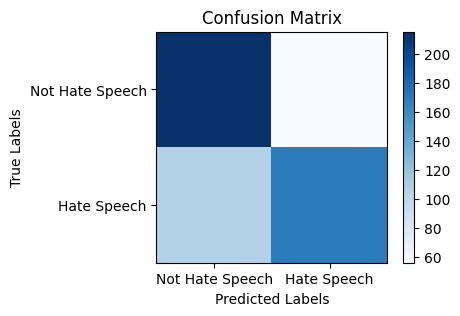

In [25]:
# Menyimpan model dengan best parameter
best_svm_unigram = SVC(**unigram_bestParams)

# Fit the model to the training data
best_svm_unigram.fit(X_train_unigram, y_train_unigram)

# Transform the test data using the same vectorizer used for training
X_test_unigram = TfidfVectorizer(ngram_range=(1,1)).fit(flat_list_transcription).transform(X_test)

# Predict the labels for the test data
y_pred_unigram = best_svm_unigram.predict(X_test_unigram)

# Menampilkan hasil pengujian
print_matrix(y_test, y_pred_unigram)

# Uni-Bigram

In [30]:
# Train set untuk training model dengan fitur uni-gram
X_train_uniBigram = feature_dataframes['unigram_bigram']
y_train_uniBigram = train_df['Is_HateComments']

In [54]:
# Training dan
gridSearch.fit(X_uniBigram_train, y_train_uniBigram)

# Get the best hyperparameters
uniBigram_bestParams = gridSearch.best_params_

# Print the best hyperparameters
print("Best hyperparameters:")
print(uniBigram_bestParams)

Best hyperparameters:
{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}


Confusion matrix:
[[209  62]
 [ 99 175]]
Accuracy: 0.7045871559633028
F1-score: 0.6849315068493151
Precision: 0.7383966244725738
Recall: 0.6386861313868614
Loss: 10.647758157152039


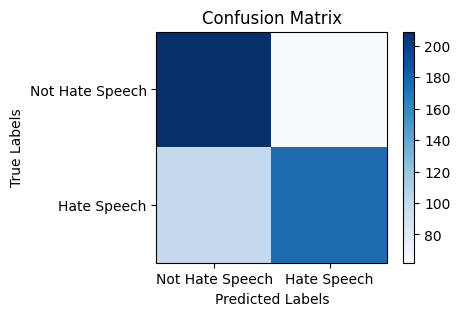

In [55]:
# Redefine svm model with best hyperparameter
best_svm_uniBigram = SVC(**uniBigram_bestParams)

# Fit the model to the training data
best_svm_uniBigram.fit(X_train_uniBigram, y_train_uniBigram)

# Transform the test data using the same vectorizer used for training
X_test_uniBigram = TfidfVectorizer(ngram_range=(1,2)).fit(flat_list_transcription).transform(X_test)

# Memprediksi label pada data testing
y_pred_uniBigram = best_svm_uniBigram.predict(X_test_uniBigram)

# Menampilkan hasil pengujian
print_matrix(y_test, y_pred_uniBigram)

# Bi-Gram

In [56]:
# Train set untuk training model dengan fitur uni-gram
X_train_Bigram = feature_dataframes['bigram']
y_train_Bigram = train_df['Is_HateComments']

In [57]:
# Training dan
gridSearch.fit(X_train_Bigram, y_train_Bigram)

# Get the best hyperparameters
Bigram_bestParams = gridSearch.best_params_

# Print the best hyperparameters
print("Best hyperparameters:")
print(Bigram_bestParams)

Best hyperparameters:
{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}


Confusion matrix:
[[161 110]
 [ 67 207]]
Accuracy: 0.6752293577981652
F1-score: 0.700507614213198
Precision: 0.6529968454258676
Recall: 0.7554744525547445
Loss: 11.705920458483918


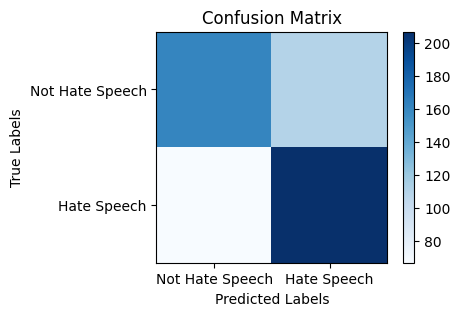

In [58]:
# Redefine svm model with best hyperparameter
best_svm_Bigram = SVC(**Bigram_bestParams)

# Fit the model to the training data
best_svm_Bigram.fit(X_train_Bigram, y_train_Bigram)

# Transform the test data using the same vectorizer used for training
X_test_Bigram = TfidfVectorizer(ngram_range=(2,2)).fit(flat_list_transcription).transform(X_test)

# Predict the labels for the test data
y_pred_Bigram = best_svm_Bigram.predict(X_test_Bigram)

print_matrix(y_test, y_pred_Bigram)

# Unigram-Trigram

In [59]:
# Train set untuk training model dengan fitur uni-gram
X_train_uniTrigram = feature_dataframes['unigram_trigram']
y_train_uniTrigram = train_df['Is_HateComments']

In [60]:
# Training dan
gridSearch.fit(X_train_uniTrigram, y_train_uniTrigram)

# Get the best hyperparameters
uniTrigram_bestParams = gridSearch.best_params_

# Print the best hyperparameters
print("Best hyperparameters:")
print(uniTrigram_bestParams)

Best hyperparameters:
{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}


Confusion matrix:
[[211  60]
 [100 174]]
Accuracy: 0.7064220183486238
F1-score: 0.6850393700787402
Precision: 0.7435897435897436
Recall: 0.635036496350365
Loss: 10.581623013318797


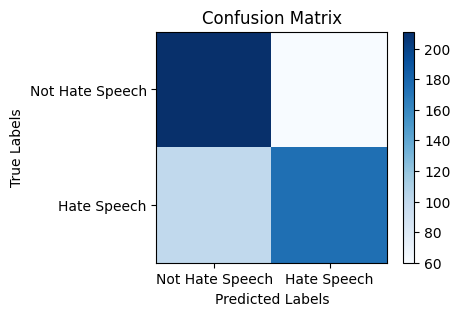

In [66]:
# Redefine svm model with best hyperparameter
best_svm_uniTrigram = SVC(**uniTrigram_bestParams)

# Fit the model to the training data
best_svm_uniTrigram.fit(X_train_uniTrigram, y_train_uniTrigram)

# Transform the test data using the same vectorizer used for training
X_test_uniTrigram = TfidfVectorizer(ngram_range=(1,3)).fit(flat_list_transcription).transform(X_test)

# Predict the labels for the test data
y_pred_uniTrigram = best_svm_uniTrigram.predict(X_test_uniTrigram)

print_matrix(y_test, y_pred_uniTrigram)

# Trigram

In [63]:
# Train set untuk training model dengan fitur tri-gram
X_train_Trigram = feature_dataframes['trigram']
y_train_Trigram = train_df['Is_HateComments']

In [67]:
# Tunning hyperprameter menggunakan gridsearch
gridSearch.fit(X_train_Trigram, y_train_Trigram)

# Get the best hyperparameters
Trigram_bestParams = gridSearch.best_params_

# Print the best hyperparameters
print("Best hyperparameters:")
print(Trigram_bestParams)

Best hyperparameters:
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


Confusion matrix:
[[ 78 193]
 [ 25 249]]
Accuracy: 0.6
F1-score: 0.6955307262569832
Precision: 0.5633484162895928
Recall: 0.9087591240875912
Loss: 14.41746135564686


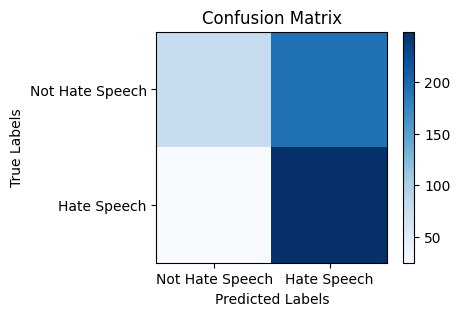

In [68]:
# Redefine svm model with best hyperparameter
best_svm_Trigram = SVC(**Trigram_bestParams)

# Fit the model to the training data
best_svm_Trigram.fit(X_train_Trigram, y_train_Trigram)

# Transform the test data using the same vectorizer used for training
X_test_Trigram = TfidfVectorizer(ngram_range=(3,3)).fit(flat_list_transcription).transform(X_test)

# Predict the labels for the test data
y_pred_Trigram = best_svm_Trigram.predict(X_test_Trigram)

print_matrix(y_test, y_pred_Trigram)